In [11]:
import math
import random

# All rolls
rolls = [[]]
# Current number of dice
dice = 8
# Constant for the Upper Confidence Bound
C = 2000
# Number of iterations for the MCST
total_iterations = 100000

class MCSTree:
  def __init__(self, t, n):
    # Value of the Node
    self.t = t
    # Number of visits of the node
    self.n = n
    # How far in the tree are we ?
    self.previousRoll = []
    # All the discarded dice
    self.discardedDice = []
    # Parent 
    self.parent = None
    # Valid node
    self.valid = True
    # Child number
    self.childNb = None
    # The six child possibilities for the dice or end turn 
    self.children = [None]*7

  def __str__(self, level=0):
    if level == 5:
      return ""
    ret = "\t"*level+"child : "+repr(self.childNb)+", passed : "+repr(self.n)+", val : "+repr(self.t)+", previous : "+repr(self.previousRoll)+", discarded : "+repr(self.discardedDice)+"\n"
    for child in self.children:
      if child != None:
        ret += child.__str__(level+1)
    return ret

def createNode(node, t, n, previousRoll, discardedDice, childNb):
  newNode = MCSTree(t, n)
  newNode.previousRoll.extend(node.previousRoll)
  newNode.previousRoll.append(previousRoll)
  newNode.discardedDice.extend(node.discardedDice)
  newNode.discardedDice.extend(discardedDice)
  newNode.parent = node
  newNode.childNb = childNb+1
  node.children[childNb] = newNode

In [12]:
# Monte Carlo Search Tree 
def MCST(root, mcst_rolls):
  global total_iterations
  rolls = mcst_rolls.copy()
  while root.n < total_iterations:
    old_rolls = rolls.copy()
    leaf = traverse(root, rolls)
    if leaf.valid == False:
      backpropagate(leaf, 0)
      leaf.valid == True
    else:
      simulation_result = rollout(leaf, rolls)
      backpropagate(leaf, simulation_result)
    rolls = old_rolls
  return best_child(root, rolls)

# Find the total number of simulations done
def root_simulation_number(node):
  while node.parent != None:
    node = node.parent
  return node

# Calculate the value of a node 
def best_ucb(node):
  global C
  old_ucb = -1
  node_num = -1
  myList = list(range(7))
  random.shuffle(myList)
  for i in myList:
    if node.children[i] != None:
      if node.children[i].n == 0:
        return node.children[i]
      N = root_simulation_number(node)
      ucb = node.children[i].t + C * math.sqrt(math.log(N.n)/node.children[i].n)
      if ucb > old_ucb:
        old_ucb = ucb
        node_num = i
  return node.children[node_num]

# Is the node not a leaf node ? 
def non_terminal(node, rolls):
  # Is it the root node 
  if node.parent == None:
    return 1
  # Has there already been 6 throws ?
  if len(node.previousRoll) == 6:
    return 0
  # No new numbers in current roll
  if all(x in node.previousRoll for x in rolls[len(node.previousRoll)]):
    return 0
  # No dice left
  if len(node.discardedDice) == 8:
    return 0
  # The choice 7 is to stop the turn now (normally already taken care of when checking no new numbers in current roll)
  if node.childNb == 7:
    return 0
  return 1

# Not possible to take this number
def impossible_action(node, rolls):
  # Continue if it is the root node
  if node.parent == None:
    return 0
  # Continue if it is the stop turn choice
  if node.childNb == 7:
    return 0
  # If the node number has already been selected previously, then abort
  if node.childNb in node.previousRoll[0:-1]:
    return 1
  # If the node number is not in the rolls, then abort
  if node.childNb not in rolls[len(node.previousRoll)-1]:
    return 1
  return 0

# Is the node a leaf node ? (0: yes, 1 : unvisited child to do, 2: no) 
def fully_expanded(node, rolls):
  if impossible_action(node, rolls):
    return -1
  if not non_terminal(node, rolls):
    return 0
  # Create the children if not already done
  if node.children[0] == None:
    for i in range(6):
      nbDiscarded = [i+1]*rolls[len(node.previousRoll)].count(i+1)
      createNode(node, 0, 0, i+1, nbDiscarded, i)
    createNode(node, 0, 0, None, [], 6)
    return 1
  # If one of the child nodes has not yet been visited
  did_visit = pick_unvisited(node)
  if did_visit > -1:
    return 1
  return 2

# Is there a child that has never been visited ?
def pick_unvisited(node):
  # randomly select one of the seven children
  myList = list(range(7))
  random.shuffle(myList)
  for i in myList:
    if node.children[i].n == 0:
      return i
  return -1

# function for node traversal
def traverse(node, rolls):
  isExpanded = fully_expanded(node, rolls)
  # While the node is not terminal, not impossible or has been visited
  while (isExpanded == 2):
    node = best_ucb(node)
    toExtend = [node.childNb]*rolls[len(node.previousRoll)-1].count(node.childNb)
    if toExtend != []:
      node.discardedDice = [s for s in node.discardedDice if s != node.childNb]
      node.discardedDice.extend(toExtend)
    rolls.append([random.randint(1, 6) for i in range(8 - len(node.discardedDice))])
    isExpanded = fully_expanded(node, rolls)
  # The node is impossible
  if isExpanded == -1:
    node.valid = False
    return node
  # The node is a terminal node
  if isExpanded == 0:
    return node
  # The node has unvisited children
  if isExpanded == 1:
    unVisited = pick_unvisited(node)
    if impossible_action(node.children[unVisited], rolls):
        node.children[unVisited].valid = False
    return node.children[unVisited]

# Result from the simulation
def result(node):
  # Player needs dice 6 to be able to win and that the sum of his points is bigger or equal to an available token
  if 6 in node.previousRoll:
    values = [node.discardedDice[j] if node.discardedDice[j] != 6 else 5 for j in range(len(node.discardedDice))]
    score = sum(values)
    i = 0
    while score-i  > 20:
      if score-i in [i[0] for i in available_pieces]:
        return available_pieces[[y[0] for y in available_pieces].index(score-i)][1]
      i += 1
  return 0

# Is the node not a leaf node ?
def rollout_non_terminal(node, rolls):
  # Has there already been 6 throws ?
  if len(node.previousRoll) == 6:
    return 0
  # No new numbers in current roll
  if all(x in node.previousRoll for x in rolls[len(node.previousRoll)-1]):
    return 0
  # No dice left
  if len(node.discardedDice) == 8:
    return 0
  # Decided to not continue playing
  if node.childNb == 7:
    return 0
  return 1

# function for the result of the simulation
def rollout(node, rolls):
  # Save values that will be changed for the rollout
  # global rolls
  oldRolls = rolls.copy()
  oldNodeRoll = node.previousRoll.copy()
  oldNodeDis = node.discardedDice.copy()
  # While the node is not terminal and not impossible, navigate through the children with random rolls
  impossible = impossible_action(node, rolls)
  while not impossible and rollout_non_terminal(node, rolls):
    rollout_policy(node, rolls)
    rolls.append([random.randint(1, 6) for i in range(8 - len(node.discardedDice))])
    impossible = impossible_action(node, rolls)
  # get the result of the final node
  myResult = result(node.parent) if impossible else result(node)
  # Load values that have been changed 
  node.previousRoll = oldNodeRoll
  node.discardedDice = oldNodeDis
  rolls = oldRolls
  return myResult

# function for randomly selecting a child node
def rollout_policy(node, rolls):
  chosen = -1
  # choose a dice that has not yet been selected
  while chosen == -1 or rolls[len(node.previousRoll)-1][chosen] in node.previousRoll:
    chosen = random.randint(0, len(rolls[len(node.previousRoll)-1])-1)
  chosenValue = rolls[len(node.previousRoll)-1][chosen]
  node.discardedDice.extend([chosenValue]*rolls[len(node.previousRoll)-1].count(chosenValue))
  node.previousRoll.append(chosenValue)

# Update the state of the current node 
def update_stats(node, result):
  node.t += result
  node.n += 1

# function for backpropagation
def backpropagate(node, node_result):
  update_stats(node, node_result)
  if (node.parent == None): return
  if result(node.parent) > node_result:
    node_result = result(node.parent)
  backpropagate(node.parent, node_result)

# function for selecting the best child
# node with highest number of visits
def best_child(node, rolls):
  global taken
  best = [-1, -1]
  for i in range(6):
    if node.children[i] != None:
      if best[1] < node.children[i].n:
        if node.children[i].childNb in rolls[-1] and node.children[i].childNb not in node.previousRoll:
          best = [i, node.children[i].n]
  return best[0] + 1

def cleanTree(root, chosen):
  for i in range(len(root.children)):
    if root.children[i].childNb != chosen:
      root.children[i] = None
  for i in range(len(root.children[chosen-1].children)):
    root.children[chosen-1].children[i] = None
  resetVisit(root.children[chosen-1])
  return root.children[chosen-1]

def resetVisit(node):
  node.t = 0
  node.n = 0
  node.discardedDice = []
  if node.parent == None: return
  resetVisit(node.parent)

In [13]:
def use_strat(which_player, dice_amnt_available, rolls, round_score, taken, dice_taken):
    #apply strategy. Output three things:
    #  - what die index is chosen: chosen
    #  - stop and pick tile:  stop
    #  - what tile is picked: what_tile
    
    what_tile = -1; # what tile to chose
    chosen = -1 # index in rolls[]
    global player0_stack, player1_stack, available_pieces
    stop = False # false means not (attempting to) take a tile
    stacks = [player0_stack, player1_stack]
    global mcst_rolls, tree
    
    if player_strategy[which_player] == 'RANDOM':
        # just pick something thats possible
        while rolls[chosen] in taken or chosen == -1:#choose a random die that is still available
            chosen = random.randint(0, dice_amnt_available-1) 
        round_score, temp_dice_amnt_available = sum_score(round_score, chosen, rolls, dice_amnt_available)

        #50% chance to try to take a tile:
        if (random.randint(0,1) == 0 and (6 in taken)) : # if 0, then take a tile if possible
            exist, opponent, tile_index = available_tile(round_score, which_player)
            if exist:
                #if on opponent stack
                if opponent:
                    what_tile = stacks[not which_player][-1]
                #if on available pieces stack
                else:
                    what_tile = available_pieces[tile_index];
                stop = True
    
    
    
    elif player_strategy[which_player] == 'GREEDY':
        high = 0
        for i in range(0, dice_amnt_available):
            sum_arr = sum_score(round_score, i, rolls, dice_amnt_available)
            sum_high = sum_arr[0]
            if rolls[i] not in taken and sum_high > high:
                high = sum_high
                chosen = i
        if dice_amnt_available < 5 and 6 not in taken:
            for i in range(0, dice_amnt_available):
                if rolls[i] == 6:
                    chosen = i
        round_score, temp_dice_amnt_available = sum_score(round_score, chosen, rolls, dice_amnt_available)
        exist, opponent, tile_index = available_tile(round_score, which_player)
        if exist and ((6 in taken) or rolls[chosen] == 6):
                #if on opponent stack
                if opponent:
                    what_tile = stacks[not which_player][-1]
                #if on available pieces stack
                else:
                    what_tile = available_pieces[tile_index];
                stop = True
        
        
        
    elif player_strategy[which_player] == 'HUMAN':
        global show_turns, show_rolls
        show_turns = 1;
        show_rolls = 1;
        print()
        
        chosen = -1;
        while (chosen == -1 or rolls[chosen] in taken):
            whatToDo = input("Choose what die/dice [6 = worm]: ")
            try:
                chosen = rolls.index(int(whatToDo));
            except ValueError:
                print(whatToDo, "is not found in the array")
            
        
        round_score, temp_dice_amnt_available = sum_score(round_score, chosen, rolls, dice_amnt_available)
        exist, opponent, tile_index = available_tile(round_score, which_player);
        if (exist and ((6 in taken) or int(whatToDo) == 6)):
            pickOne=-1;
            while (pickOne != "1" and pickOne != "0"):
                print("You have rolled ", round_score)
                pickOne = input("Do you want to pick a tile? [1:yes, 0: no]");
                if pickOne == "1":
                    if opponent:
                        what_tile = stacks[not which_player][-1]
                    #if on available pieces stack
                    else:
                        what_tile = available_pieces[tile_index];
                    stop = True; 
                else:
                    stop = False;
                    
    elif player_strategy[which_player] == 'MCST':
        if taken == [0]:
            tree = MCSTree(0,0)
            mcst_rolls = []
        mcst_rolls.append(rolls)
        chosen = MCST(tree, mcst_rolls)
        #print(tree)
        tree = cleanTree(tree, chosen)
        chosen = rolls.index(chosen)
        round_score, temp_dice_amnt_available = sum_score(round_score, chosen, rolls, dice_amnt_available)
        exist, opponent, tile_index = available_tile(round_score, which_player)
        print(exist)
        if exist  and ((6 in taken) or 6 == rolls[chosen]):
            #if on opponent stack
            if opponent:
                what_tile = stacks[not which_player][-1]
            #if on available pieces stack
            else:
                what_tile = available_pieces[tile_index]; 
            stop = True
    
    elif player_strategy[which_player] == 'AI':
        
        roundscore = 0;
        for i in taken: roundscore = roundscore + i  #different from how other strategies use round_score
        #print("taken: ", taken)
        state = convertGameStateFormat(available_pieces, taken, rolls, player0_stack, player1_stack, which_player)
        #print(state)
        AI_grill = state[0];
        AI_rolls = state[4];
        AI_taken = state[3];
        AI_selfstash = state[2]
        AI_oppstash = state[1]
        current_winner, score0, score1 = getResult();
        if (which_player):
            AI_score = score1
            AI_opponent_score = score0
        else:
            AI_score = score0
            AI_opponent_score = score1
        
        """ Code adapted from github """
        # dices that may be kept before rerolling
        candidates = [n for n in range(6) if AI_rolls[n]>0 and AI_taken[n]==0]
        
        AI_stop = []
        for action in candidates:
            if action==0:
                new_score = round_score + AI_rolls[0]*5
                if new_score>=AI_grill[0] or (AI_oppstash and AI_oppstash[-1]==new_score):
                    AI_stop.append(6) # you can take a tile
            else:
                # cannot stop if score not at least bigger than the smallest available tile
                new_score = round_score + AI_rolls[action]*action
                
                if action and not AI_taken[0]:
                    new_score = 0
                if AI_grill and (new_score>=AI_grill[0] or (AI_oppstash and AI_oppstash[-1]==new_score) ):
                    AI_stop.append(6+action)
        
        
        
        candidates = candidates + AI_stop
        if len(candidates) == 0:
            # no dice available -> this roll is lost
            print("we are failing")
        # determine inputs (originally state.inputs())
        INPUTS = 237 # always
        res = np.zeros((1, INPUTS))
        ptr = 0
        # stash
        for t in AI_grill:
            res[0,ptr+t-21] = 1
        ptr += 16
        # opponent top tile
        if AI_oppstash:
            res[0,ptr+AI_oppstash[-1]-21] = 1
        ptr += 16
        # my top tile
        if AI_selfstash:
            res[0,ptr+AI_selfstash[-1]-21] = 1
        ptr += 16
        # score delta
        res[0,ptr+40+AI_score-AI_opponent_score] = 1
        ptr += 81
        # dices
        for s in range(6):
            res[0,ptr+s*9+AI_taken[s]] = 1
        ptr += 6*9
        # roll
        for s in range(6):
            res[0,ptr+s*9+AI_rolls[s]] = 1
        ptr += 6*9
        allQ = q.predict(res);
        EPSILON = 0.1
        if len(candidates) == 0:
            # no dice available -> this roll is lost
            action = -1;  #return -1, [], np.empty((0,0))
        if random.random() < EPSILON:
            # e-greedy exploration
            action = random.choice(candidates)
        else:
            # exploitation: return best action
            action = candidates[ max(list(range(len(candidates))), key=lambda i: allQ[0,candidates[i]]) ]
        
        if (action == 0): # take worm
            stop = False;
            chosen = rolls.index(6)
        elif (action >= 0 and action < 6): # take a dice
            stop = False;
            chosen = rolls.index(action)
        elif (action == 6):
            stop = True
            chosen = rolls.index(6)
        else:
            stop = True
            chosen = rolls.index(action-6)
            
        if stop == True:
            exist, opponent, tile_index = available_tile(new_score, which_player)
            if opponent: what_tile = stacks[not which_player][-1]  
            else: what_tile = available_pieces[tile_index];
    
    
    return chosen, stop, what_tile

In [14]:
def makeTurn(which_player):    
    #take information from the game:
    global available_pieces, player0_stack, player1_stack, show_rolls
    stacks = [player0_stack, player1_stack] #for easily accessing the correct stack using a number
    round_score = 0; # score obtained during this round
    dice_amnt_available = 8; #initially, there are 8 dice
    dice_taken = []; #dice that are set aside
    taken = [0]; # the types of dice that cannot be taken again
    rolls = [0]*dice_amnt_available; #empty array for the rolls
    stop = False; # stop throwing and take a dice
    failed = False; # turn is ruined
    
    if show_turns: # print the info about the game stuff
        print("Player ", int(which_player), " ( STRAT:", player_strategy[which_player], ") 's turn with stack: \n")
        display_tiles(stacks[which_player], 1)
        print("Opponent player ", int(not which_player), " ( STRAT:", player_strategy[not which_player], ") has stack: \n")
        display_tiles(stacks[not which_player], 1)

    while not stop:
        # roll with the remaining dice (6 = worm with value 5)
        rolls = [random.randint(1, 6) for i in range(dice_amnt_available)] 
        # check if there are any options or round is over
        if all(x in taken for x in rolls):
            if(show_rolls):
                print('Dice rolled: ', rolls, " FAIL!")
            return 0 # round is failed
        
        if show_rolls:
            print('Dice rolled: ', rolls)

        # apply strategy
        chosen, stop, what_tile = use_strat(which_player, dice_amnt_available, rolls, round_score, taken, dice_taken);

        #check if strategy makes a valid move and is not cheating:
        stop, dice_amnt_available, round_score, taken, dice_taken, round_score = checkValidMove(rolls, dice_amnt_available, taken, dice_taken, chosen, stop, what_tile, round_score); 
        if (show_rolls): 
            print('Die type taken: ', rolls[chosen], " \t Dice taken: ", dice_taken, '\t score until now: ', round_score)
    
    return 1

#calculates the score after picking a certain value of the rolled dice
def sum_score(round_score, chosen, rolls, dice_amnt_available):
    for i in range(dice_amnt_available):
            if rolls[i] == rolls[chosen]:
                dice_amnt_available -= 1
                round_score += rolls[chosen] if rolls[chosen] < 6 else 5 # number 6 is the worm which is worth 5 points
    return round_score, dice_amnt_available


#returns what tile is available for picking
def available_tile(round_score, which_player):
    # check if a tile is available for grabbing
    global available_pieces, player0_stack, player1_stack
    stacks = [player0_stack, player1_stack]

    exist = False #false if no tile is available, true otherwise
    opponent = False #true if the available tile is the opponent's

    closest_lower_score = float('-inf')
    tile_index = -1  # index of the grill

    if (len(stacks[not which_player]) > 0 and round_score == stacks[not which_player][-1][0]):
        opponent = True # tile is on opponents stack
        exist = True # thus it exists
    else:
        for i, tile in enumerate(available_pieces): # go over all grill pieces
            if tile[0] == round_score: # found it on the grill
                tile_index = i
                exist = True
                break
            elif tile[0] < round_score and tile[0] > closest_lower_score:
                closest_lower_score = tile[0] #tile is not on grill, but a lower value is
                exist = True
                tile_index = i
                
    return exist, opponent, tile_index


#updates the arrays that contain the taken dice
def take_dice(rolls, chosen, taken, temp_dice_taken, dice_amnt_available):
    taken.append(rolls[chosen])
    
    #adds the values of the taken dice to an array
    for i in range(0, dice_amnt_available):
        if rolls[i] == rolls[chosen]:
            temp_dice_taken.append(rolls[chosen])
    
    return taken, temp_dice_taken

def checkValidMove(rolls,dice_amnt_available, taken, dice_taken, chosen, stop, what_tile, round_score):
    global player0_stack, player1_stack, available_pieces
    
    if (rolls[chosen] in taken):
        raise Exception("Cannot take that type of die")
    
    round_score, temp_dice_amnt_available = sum_score(round_score, chosen, rolls, dice_amnt_available)
    temp_taken, temp_dice_taken = take_dice(rolls, chosen, taken, dice_taken, dice_amnt_available)
    dice_amnt_available = temp_dice_amnt_available;
    taken = temp_taken;
        
    if stop:  
        exist, opponent, tile_index = available_tile(round_score, which_player)
        if exist and (6 in taken):
                #if on opponent stack
                if opponent:
                    stacks[which_player].append(stacks[not which_player][-1])
                    stacks[not which_player].pop()
                #if on available pieces stack
                else:
                    stacks[which_player].append(available_pieces[tile_index])
                    available_pieces.remove(available_pieces[tile_index])
                stop = True
        else:
            print("Stopping and trying to take: ", available_pieces[tile_index], "with dices: ", dice_taken)
            raise Exception("Taking tile is not possible")
        # check if player has worm
    

    # Extra check for when you dont want to stop when all dice are rolled and can take a tile
    if (not stop and rolls.count(rolls[chosen]) == len(rolls)):
        # edge case check
        exist, opponent, tile_index = available_tile(round_score, which_player)
        if exist and (6 in taken):
                #if on opponent stack
                if opponent:
                    what_tile = stacks[not which_player][-1]
                #if on available pieces stack
                else:
                    what_tile = available_pieces[tile_index];
                stop = True
    
    return stop, dice_amnt_available, round_score, taken, dice_taken, round_score

    
def update_score_progression(which_player):
    global score0_progression, score1_progression, roundnumber, player0_stack, player1_stack
    if (which_player):
            score1_progression.append( sum(piece[1] for piece in player1_stack));
    else:
            score0_progression.append( sum(piece[1] for piece in player0_stack));
            
            
def convertGameStateFormat(available_pieces, taken, rolls, player0_stack, player1_stack, which_player):
    # convert it for AI model
    state  = ([[item[0] for item in available_pieces]])
    if(which_player):
        state += [[item[0] for item in player0_stack]]
        state += [[item[0] for item in player1_stack]]
    else:
        state += [[item[0] for item in player1_stack]]
        state += [[item[0] for item in player0_stack]]
    taken_converted = [0] *6
    for i in taken:
        if (i<6 and i>0):
            taken_converted[i] = 1;
        elif(i==6):
            taken_converted[0] = 1; #worm
    
    state += [taken_converted]
    rolls_converted = [0] *6;
    for i in rolls:
        if (i<6):
            rolls_converted[i] += 1;
        else:
            rolls_converted[0] += 1; #worm
    state += [rolls_converted]

    return state

            
# After game is finished:
def getResult():
    global player0_stack, player1_stack
    score0 = sum(piece[1] for piece in player0_stack);
    score1 = sum(piece[1] for piece in player1_stack);
    
    if (score0>score1):
        winner = 0
    elif (score1>score0):
        winner = 1
    else:
        winner = -1; #draw
    
    return winner, score0, score1

        
#Functions to display rounds, throws etc. below this line
def display_stacks():
    global player0_stack, player1_stack
    #print('player 0 tiles: ', player0_stack)
    #print('player 1 tiles: ', player1_stack)
    
def display_end_result(winner, score0, score1):
    global player_strats, player0_stack, player1_stack, roundnumber
    
    print("-------   GAME RESULTS: -------\n");
    print("Player 0 ( STRAT:", player_strategy[0], "):", score0, " worms")
    display_tiles(player0_stack, 1);
    
    print("Player 1 ( STRAT:", player_strategy[1], "):", score1, " worms")
    display_tiles(player1_stack, 1);
    
    print("\nRounds played: ", roundnumber);
    
    if (winner != -1):
        print("\nWINNER: player ", winner, "!! ( ", player_strategy[winner], " )" )
    else:
        print("\n Its a draw...");


def display_score_progression(prog0, prog1):
    global player_strats
    # Plotting the variables
    label0= 'Player 0: ' + player_strategy[0];
    label1= 'Player 1: ' + player_strategy[1];
    plt.plot(prog0, 's-', linewidth=1, markersize=5, label=label0)
    plt.plot(prog1, 's-', linewidth=1, markersize=5, label=label1)

    # Adding labels and title
    plt.xlabel('Round')
    plt.ylabel('Score')
    plt.title('Round score progression')

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()
   


def display_tiles(tiles,tab):
    tiles_str = ", ".join([f"[{number} {colored('§' * worm_count, 'red')}]" for number, worm_count in tiles])
    if (tab):
        print(f"\t stack: [{tiles_str}] <-- top of stack\n")
    else:
        print(f"[{tiles_str}]\n")
        






Grill: 
[[21 §], [22 §], [23 §], [24 §], [25 §§], [26 §§], [27 §§], [28 §§], [29 §§§], [30 §§§], [31 §§§], [32 §§§], [33 §§§§], [34 §§§§], [35 §§§§], [36 §§§§]]

Player  1  ( STRAT: GREEDY ) 's turn with stack: 

	 stack: [] <-- top of stack

Opponent player  0  ( STRAT: GREEDY ) has stack: 

	 stack: [] <-- top of stack

Dice rolled:  [2, 1, 5, 3, 5, 2, 6, 1]
Die type taken:  5  	 Dice taken:  [5, 5] 	 score until now:  10
Dice rolled:  [2, 3, 6, 1, 6, 2]
Die type taken:  6  	 Dice taken:  [5, 5, 6, 6] 	 score until now:  20
Dice rolled:  [1, 1, 5, 6]
Die type taken:  1  	 Dice taken:  [5, 5, 6, 6, 1, 1] 	 score until now:  22

Grill: 
[[21 §], [23 §], [24 §], [25 §§], [26 §§], [27 §§], [28 §§], [29 §§§], [30 §§§], [31 §§§], [32 §§§], [33 §§§§], [34 §§§§], [35 §§§§], [36 §§§§]]

Player  0  ( STRAT: GREEDY ) 's turn with stack: 

	 stack: [] <-- top of stack

Opponent player  1  ( STRAT: GREEDY ) has stack: 

	 stack: [[22 §]] <-- top of stack

Dice rolled:  [3, 5, 3, 5, 4, 4, 2, 4]
D

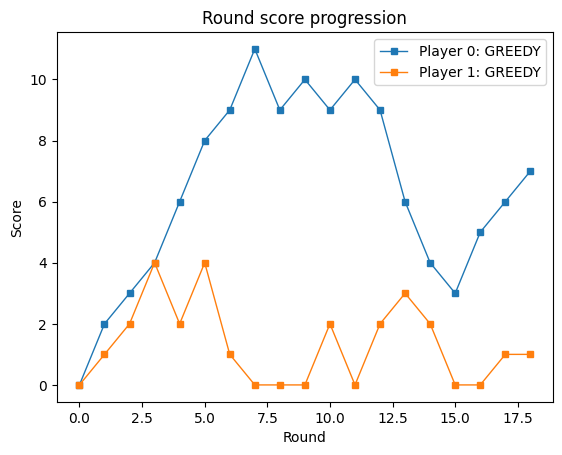

In [18]:
#### Advance the game
import random
import matplotlib.pyplot as plt
import copy
from termcolor import colored
import numpy as np
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential, load_model


random.seed(203)

# player strats: "RANDOM", "GREEDY", "HUMAN"
show_turns = 1; # print the results of each turn
show_rolls = 1; # print the rolls after each throw

# game state variables
roundnumber = 0;
available_pieces = [(21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 2), (27, 2), (28, 2), (29, 3), (30, 3), (31, 3), (32, 3), (33, 4), (34, 4), (35, 4), (36, 4)];
player0_stack= []; # last index is top of pile
player1_stack = [];
score0_progression = [0]; # round 0, 0 zero points
score1_progression = [0]; 

# round state variables
which_player = 1; # whose turn it is, 1 always begins
player_strategy = ['GREEDY', 'GREEDY']
stacks = [player0_stack, player1_stack]


##### AI setup variables
fname = "best_strategy.h5";
inputs=0
layers=3
width=0
if fname.find('.h5') == -1:
    if width == 0:
        width = inputs
    fname = '%s-inputs%d-hidden%d-width%d.h5' % (fname, inputs, layers, width)
q = load_model(fname)



while (len(available_pieces) > 0): 
    roundnumber+=which_player; #adds 1 when its player 1s turn
    
    if (roundnumber > 500):
        raise Exception("Taking too long")
    
    if show_turns:
        print("\nGrill: ")
        display_tiles(available_pieces,0)
        
    success = makeTurn(which_player) # success means a tile is taken from the grill or opponent stack

    if (not success and len(stacks[which_player]) > 0): # put a tile back if possible
        if show_turns : print("putting a tile back");
        if (which_player == 0):
            tile = player0_stack[-1]; #what tile are we talking about
            player0_stack.pop(); # remove this last tile from stack
        else:
            tile = player1_stack[-1]; #what tile are we talking about
            player1_stack.pop(); # remove this last tile from stack
        available_pieces.append(tile)  # Add the missing piece to the end
        available_pieces = sorted(available_pieces, key=lambda x: x[0])  # Sort the grill to make it in order
        if (tile != available_pieces[-1]):
            available_pieces.pop(); # flip the last tile only if it is not the one put back (game rules)

    update_score_progression(which_player);
    which_player = not which_player; # switch players

print("-------------------------- GAME FINISHED ---------------------");
winner, score0, score1 = getResult();
display_end_result(winner, score0, score1);
display_score_progression(score0_progression, score1_progression)